<h2>Imports</h2>
<ul>
    <li>Numpy</li>
    <li>Pandas</li>
    <li>Matplotlib</li>
    <li>Seaborn</li>
    <li>Scikit-Learn</li>
</ul>

In [9]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import copy

# Scikit_Learn Imports
from sklearn.datasets import fetch_openml
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.utils import shuffle


<h2>Load Dataset</h2>

In [3]:
mnist = fetch_openml('mnist_784')

e:\tuts\Machine_Learning_Fall_1402\BabaAli\Projects\ML_Project_no3\.venv\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X = mnist.data
y = mnist.target

<h2>Visualize Dataset</h2>
<ul>
    <li>Some of data</li>
    <li>Average data</li>
</ul>

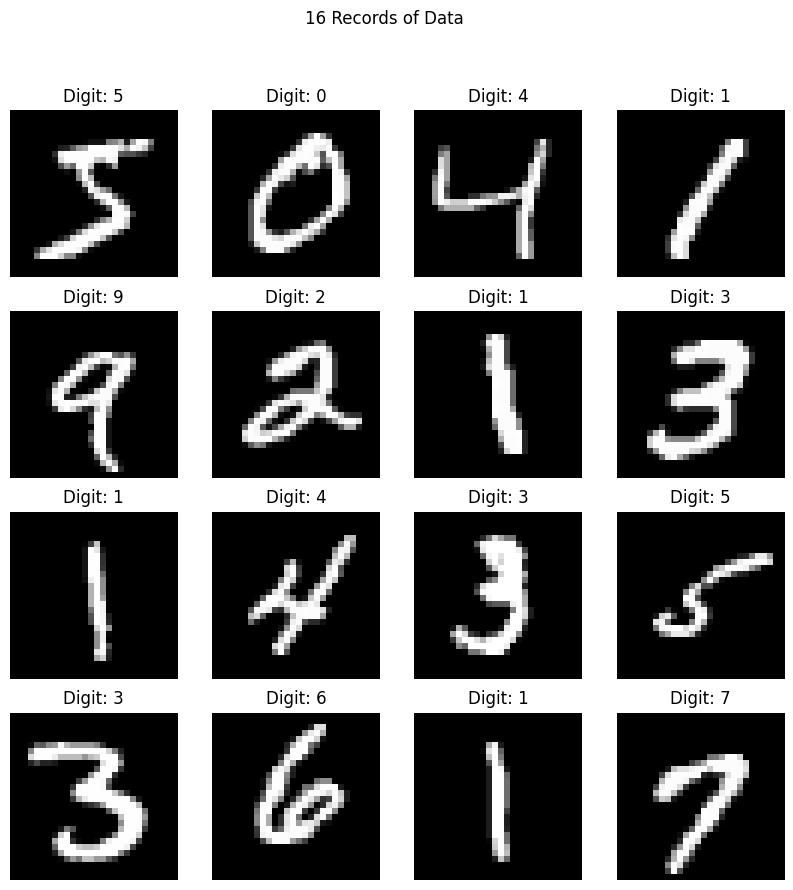

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image = X.iloc[i].values.reshape(28, 28)  # Reshaping flat imgae to its first shape
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Digit: {y[i]}")
    ax.axis('off')

plt.suptitle("16 Records of Data")
plt.show()

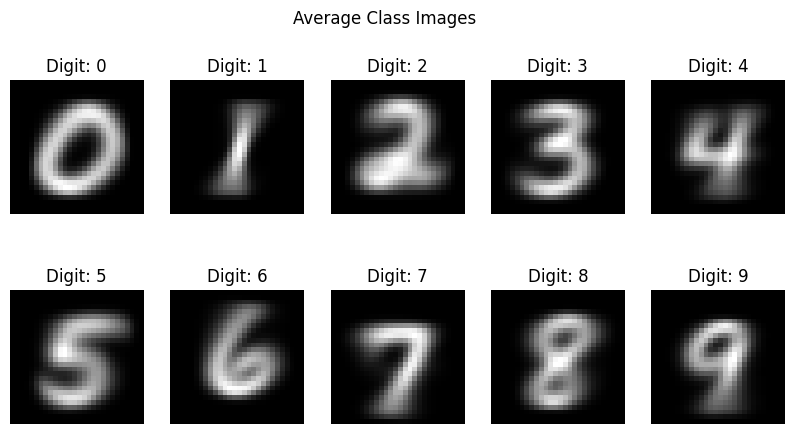

In [6]:

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for digit in range(10):
    # Extract all images for this digit
    digit_images = X[y == str(digit)]

    # Calculate the average image
    average_image = np.array(np.mean(digit_images, axis=0)).reshape(28, 28)

    # Plot the average image
    ax = axes[digit // 5, digit % 5]  # Calculate the grid index here
    ax.imshow(average_image, cmap='gray')
    ax.set_title(f"Digit: {digit}")
    ax.axis('off')

plt.suptitle("Average Class Images")
plt.show()


<h2>Preprocessing</h2>
<ul>
    <li>Missing Values (Already Done)</li>
    <li>Drop Duplicates (Already Done)</li>
    <li>Handle Categorical Feaetures (Already Done)</li>
    <li>Normalizing (Using Standard Normalization)</li>
</ul>
<h4><b>NOTE</b></h4>
<p>Preprocessing can be really chalenging on datasets but MNIST is a really famous and clean dataset so I just applied normalization before scalinng down data because of better perfomance of LDA with normalization and skiped other steps of pre processing</p>

In [7]:
scaler = StandardScaler()
standard_X = scaler.fit_transform(X)

<h2>Split Train & Test data</h2>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(standard_X, y, test_size=0.2, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56000, 784)
(14000, 784)
(56000,)
(14000,)


<h2>Appling LDA</h2>
<p><b>Approach:</b> Scale down data to 2, 3, 4, ..., 9 and compare them</p>
<p><b>NOTE:</b> Original data dimension size is 784</p>

In [11]:
# Define the range of dimensions to scale down (2, 3, 4, ..., 8, 9)
dimensions = range(2, 10)

# Define Repeated K-Fold (Folds=5, Repeates=10)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Dictionary to store accuracies for each dimension
accuracy_dict_val = {dim: [] for dim in dimensions}
accuracy_dict_train = {dim: [] for dim in dimensions}
perceptrons_dict = {dim: [] for dim in dimensions}
ldas = []

for dim in dimensions:
    
    # Shuffle the train data 10 times 
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # Perform repeated K-Fold CV
    for train_index, val_index in rkf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        lda = LDA(n_components=dim) # Apply LDA to reduce dimensions
        X_reduced_train_fold = lda.fit_transform(X_train_fold, y_train_fold)
        X_reduced_val_fold = lda.transform(X_val_fold)
        ldas.append(copy.deepcopy(lda))


        # Train the model
        perceptron = Perceptron()
        perceptron.fit(X_reduced_train_fold, y_train_fold)

        # Evaluation
        # Validation data
        accuracy_val = accuracy_score(y_val_fold, perceptron.predict(X_reduced_val_fold))
        accuracy_dict_val[dim].append(accuracy_val)

        # Train data
        accuracy_train = accuracy_score(y_train_fold, perceptron.predict(X_reduced_train_fold))
        accuracy_dict_train[dim].append(accuracy_train)

        # Save models
        perceptrons_dict[dim].append(copy.deepcopy(perceptron))


<h2>Boxplots of all dimensions</h2>

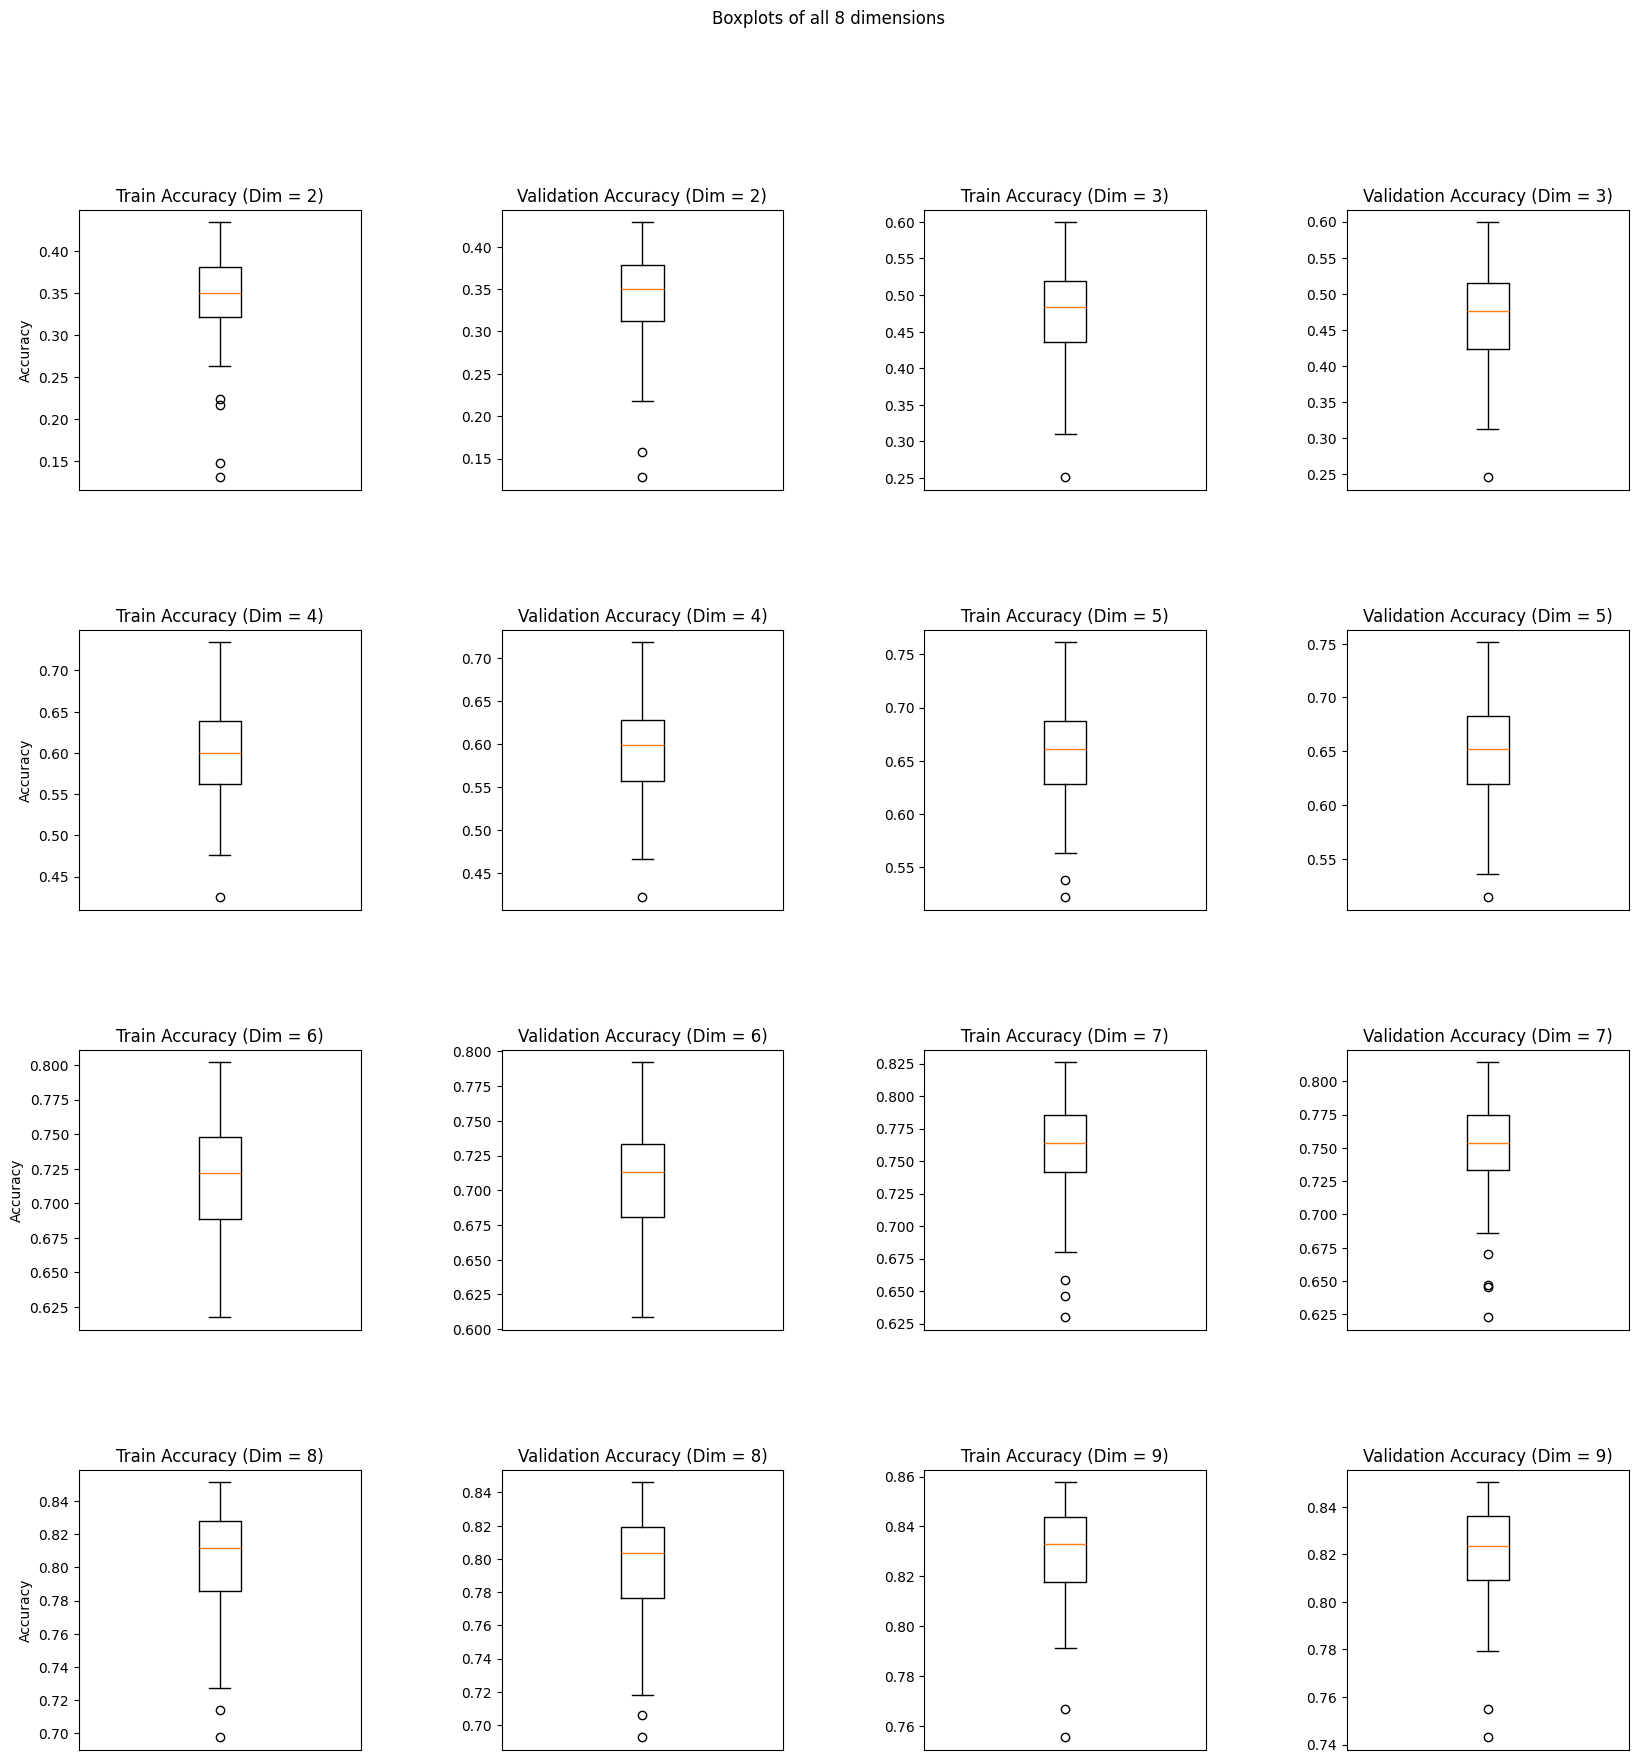

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(0, 16, 2):
    ax_1 = axes[i // 4, i % 4]
    ax_2 = axes[i // 4, (i % 4) + 1]
    ax_1.boxplot(accuracy_dict_train[list(accuracy_dict_train.keys())[i // 2]])
    ax_2.boxplot(accuracy_dict_val[list(accuracy_dict_val.keys())[i // 2]])
    ax_1.xaxis.set_visible(False)
    ax_2.xaxis.set_visible(False)
    ax_1.set_title(f"Train Accuracy (Dim = {(i // 2) + 2})")
    ax_2.set_title(f"Validation Accuracy (Dim = {(i // 2) + 2})")

axes[0, 0].set_ylabel("Accuracy")
axes[1, 0].set_ylabel("Accuracy")
axes[2, 0].set_ylabel("Accuracy")
axes[3, 0].set_ylabel("Accuracy")
plt.suptitle("Boxplots of all 8 dimensions")
plt.show()

<h2>Compare models in different dimensions</h2>
<h4>Underfitting</h4>
<ul>
    <li>Low average accuracy on validation dataset</li>
    <li>Low average accuracy on training dataset</li>
</ul>
<h4>Overfitting</h4>
<ul>
    <li>High training accuracy but low accuracy on validation dataset</li>
    <li>Decrease in accuracy with increasing in dimensionality</li>
</ul>
<h4>Results</h4>
<p>As you can see the average accuracy until dim=5 is low and this is the sign of underfitting abd also you can see the average accuracy on both training and validation data increases while dimention is increasing, so this means that there is no overfitting here and this is reasonable too becasue the initial dimensions size is 784 and scaling it down to 9 can be a good choice and maybe more dimension size make the functionaly even better (e.g. dim=14). So under these conditions I choose dim=9 and test this model on test data further and report the results.</p>

<h2>Evaluate the model on test data</h2>
<h5><b>NOTE:</b> I get the best model of dim=9 and evaluate this model on test data and reports the metrics further.</h5>

<h4>Get the best model</h4>

In [13]:
# Get the best model
best_accuracy = 0
best_model = None

for i in range(len(accuracy_dict_val[9])):
    if best_accuracy < accuracy_dict_val[9][i]:
        best_accuracy = accuracy_dict_val[9][i]
        best_model = copy.deepcopy(perceptrons_dict[9][i])

<h4>Transform test data to 9 dimensions scale</h4>

In [20]:
best_index = accuracy_dict_val[9].index(best_accuracy) # Get the best LDA to transform test data
X_test_reduced = ldas[350 + best_index].transform(X_test) # Transform test data

<h4>Evaluate best model on test data</h4>

In [21]:
# Evaluate
y_pred = best_model.predict(X_test_reduced)

# Metrics
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_mat = confusion_matrix(y_test, y_pred)

<h4>Show the results (Evaluation Metrics)</h4>

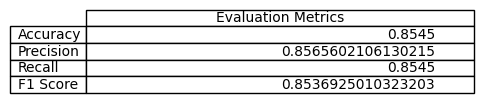

In [22]:
table_values = [[acc], [pre], [rec], [f1]]
col_labels = ['Evaluation Metrics']
row_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(5, 0.5))
plt.table(cellText=table_values, colLabels=col_labels, rowLabels=row_labels, loc='center')
plt.axis('off')
plt.show()

<h4>Show the results (Confusion Matrix)</h4>

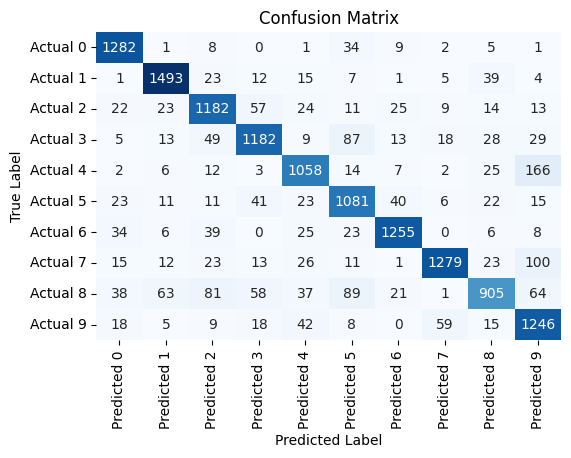

In [23]:
plt.figure(figsize=(6, 4))
sb.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5', 'Predicted 6', 'Predicted 7', 'Predicted 8', 'Predicted 9'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5', 'Actual 6', 'Actual 7', 'Actual 8', 'Actual 9'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<h4>Best parameters (Model=Perceptron)</h4>

In [24]:
print(best_model.get_params())

{'alpha': 0.0001, 'class_weight': None, 'early_stopping': False, 'eta0': 1.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
